In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score


In [3]:
datos = pd.read_csv("events_up_to_01062018.csv",low_memory=False)

In [4]:
labels = pd.read_csv("labels_training_set.csv",low_memory=False)

In [6]:
labels['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341681 entries, 0 to 2341680
Data columns (total 23 columns):
timestamp                   object
event                       object
person                      object
url                         object
sku                         float64
model                       object
condition                   object
storage                     object
color                       object
skus                        object
search_term                 object
staticpage                  object
campaign_source             object
search_engine               object
channel                     object
new_vs_returning            object
city                        object
region                      object
country                     object
device_type                 object
screen_resolution           object
operating_system_version    object
browser_version             object
dtypes: float64(1), object(22)
memory usage: 410.9+ MB


In [4]:
datos['timestamp'] = pd.to_datetime(datos['timestamp'])

In [5]:
datos['mes'] = datos['timestamp'].dt.month

In [6]:
datos['mes'].value_counts()

5    1713920
4     309849
3     193790
2      73541
1      50581
Name: mes, dtype: int64

In [8]:
datos.event.value_counts()

viewed product       1248124
brand listing         216312
visited site          204069
ad campaign hit       191388
generic listing       160176
searched products     130616
search engine hit     106406
checkout               65315
staticpage             11201
conversion              7091
lead                     983
Name: event, dtype: int64

In [10]:
datos.sample()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
2242067,2018-05-29 15:49:08,visited site,281194a9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,Returning,Unknown,Unknown,Brazil,Computer,1920x1080,Windows 7,Chrome 66.0


### Cantidad de eventos por sesión de compra

In [9]:
def mostrar(df):    
    dic_events = {}
    person = ""
    purchase = False
    for index, row in df.iterrows():  
        event = row["event"]
        if (event == "conversion"):
            purchase = True
            continue
        if (purchase):                        
            if (row['new_vs_returning'] == 'New' or row['new_vs_returning'] == 'Returning'):
                purchase = False
                continue
            if (event not in dic_events):
                dic_events[event] = 1
            else:
                dic_events[event] += 1                       
    return pd.Series(dic_events)

In [10]:
h = datos[['person','timestamp','event','new_vs_returning']]
h = h.sort_values(by=['person','timestamp'],ascending=False)
g = mostrar(h)

In [11]:
g

ad campaign hit       6899
generic listing       7919
checkout              8231
viewed product       51247
searched products     6033
search engine hit     3906
brand listing        11055
staticpage             544
lead                     5
dtype: int64

In [12]:
datos.event.value_counts().values

array([1248124,  216312,  204069,  191388,  160176,  130616,  106406,
         65315,   11201,    7091,     983])

### Armamos el train con el id persona y la cantidad de cada evento de cada uno de los id como columnas

In [11]:
pd.set_option('use_inf_as_na', True)

In [12]:
eventos_x_person = datos[['person','event','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack(-1)
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.reset_index(level=0,drop=False)
eventos_x_person

event,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
0,0008ed71,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0
1,00091926,15.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,372.0,34.0
2,00091a7a,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0
3,000ba417,1.0,24.0,6.0,1.0,14.0,NaN,1.0,NaN,NaN,153.0,6.0
4,000c79fe,1.0,NaN,1.0,NaN,1.0,NaN,1.0,9.0,NaN,3.0,1.0
5,000e4d9e,19.0,17.0,1.0,NaN,17.0,NaN,5.0,NaN,NaN,339.0,13.0
6,000e619d,6.0,11.0,1.0,NaN,8.0,NaN,3.0,6.0,NaN,28.0,5.0
7,001001be,NaN,NaN,3.0,1.0,3.0,NaN,NaN,17.0,NaN,41.0,3.0
8,0010e89a,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
9,0016c4b5,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [13]:
eventos_x_person = eventos_x_person.fillna(0)

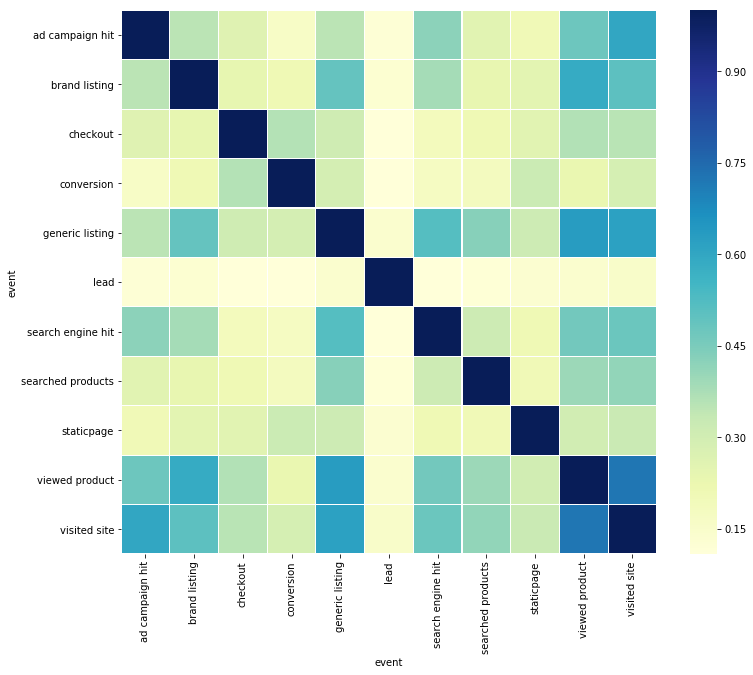

In [14]:
corrmat = eventos_x_person.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

Saco los 2 features con menos correlación, y podemos notar una gran similitud entre viewed product y visited site.

In [15]:
eventos_x_person.drop(columns=['lead','ad campaign hit','search engine hit'],inplace=True)

In [16]:
eventos_x_person = pd.merge(eventos_x_person,labels,on='person',how='left')
eventos_x_person

,person,brand listing,checkout,conversion,generic listing,searched products,staticpage,viewed product,visited site,label
0,0008ed71,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
1,00091926,25.0,2.0,0.0,0.0,0.0,0.0,372.0,34.0,NaN
2,00091a7a,5.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,NaN
3,000ba417,24.0,6.0,1.0,14.0,0.0,0.0,153.0,6.0,NaN
4,000c79fe,0.0,1.0,0.0,1.0,9.0,0.0,3.0,1.0,0.0
5,000e4d9e,17.0,1.0,0.0,17.0,0.0,0.0,339.0,13.0,NaN
6,000e619d,11.0,1.0,0.0,8.0,6.0,0.0,28.0,5.0,NaN
7,001001be,0.0,3.0,1.0,3.0,17.0,0.0,41.0,3.0,NaN
8,0010e89a,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
9,0016c4b5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN


In [18]:
eventos_x_person = eventos_x_person.dropna()
eventos_x_person

,person,brand listing,checkout,conversion,generic listing,searched products,staticpage,viewed product,visited site,label
0,0008ed71,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
4,000c79fe,0.0,1.0,0.0,1.0,9.0,0.0,3.0,1.0,0.0
10,001802e4,0.0,1.0,0.0,4.0,4.0,0.0,4.0,1.0,0.0
12,0019e639,165.0,15.0,2.0,28.0,11.0,0.0,189.0,19.0,0.0
14,001b0bf9,1.0,2.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0
15,001ca5ee,7.0,1.0,0.0,8.0,0.0,0.0,52.0,15.0,0.0
16,001dfc31,0.0,0.0,0.0,2.0,0.0,0.0,18.0,4.0,0.0
17,001e9aea,4.0,3.0,0.0,0.0,0.0,0.0,17.0,7.0,0.0
18,0020152e,0.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0
24,002b0188,17.0,1.0,0.0,3.0,0.0,0.0,12.0,2.0,0.0


/home/mariano/ENTER/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/mariano/ENTER/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/mariano/ENTER/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/mariano/ENTER/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


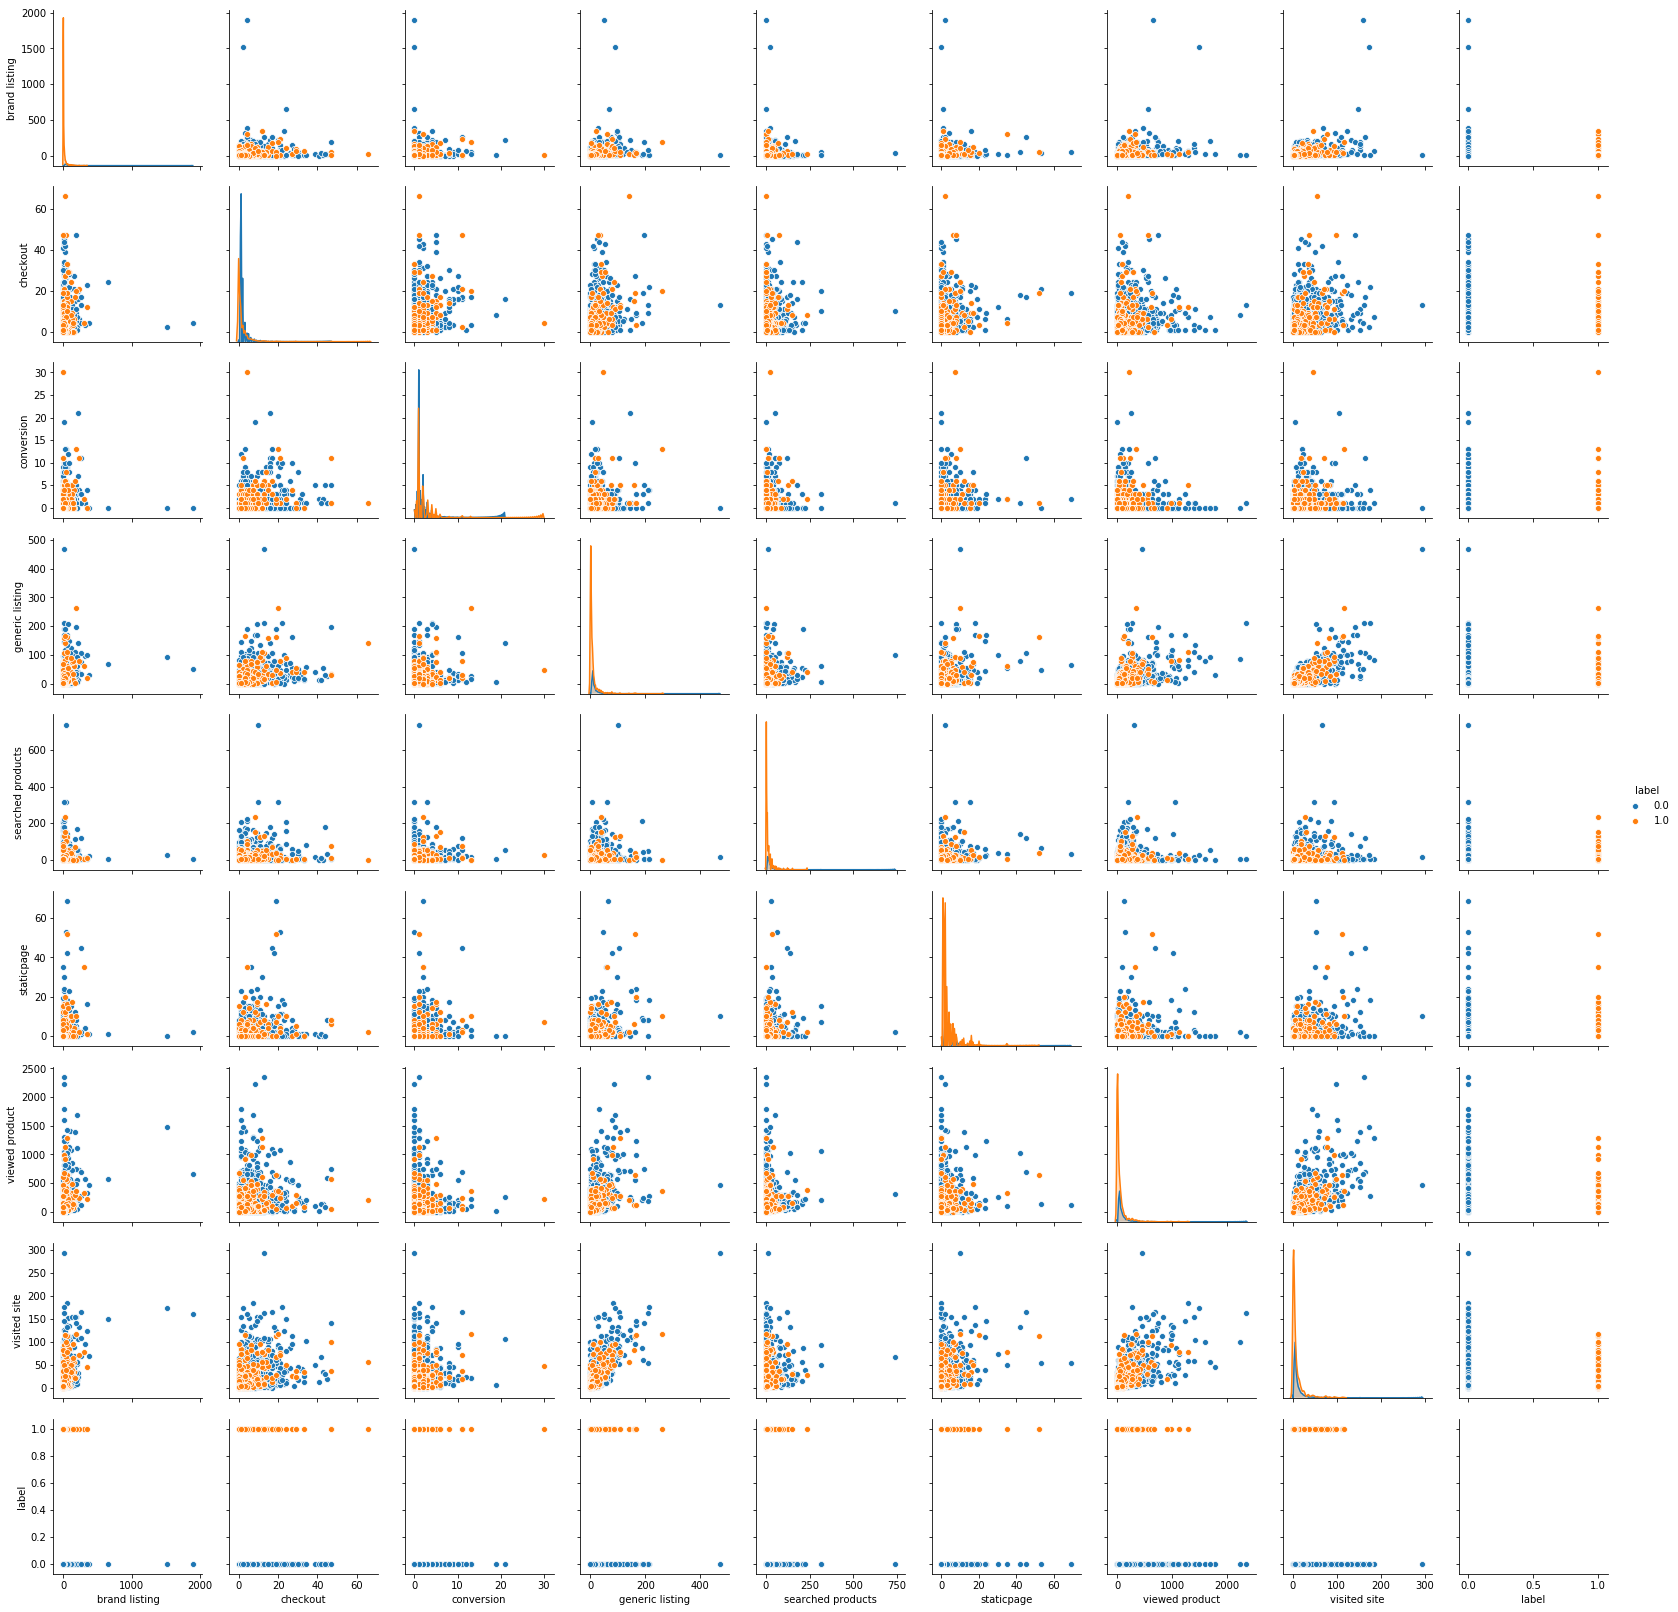

In [19]:
sns.pairplot(eventos_x_person, hue="label")

In [20]:
eventos_x_person.label.value_counts()

0    34536
1     4293
Name: label, dtype: int64

g /= eventos_x_person.conversion.sum()

g

    eventos_x_person[f1] = eventos_x_person[f1] * g[f1]
    eventos_x_person[f2] = eventos_x_person[f2] * g[f2]
    eventos_x_person[f3] = eventos_x_person[f3] * g[f3]
    eventos_x_person[f5] = eventos_x_person[f5] * g[f5]
    eventos_x_person[f6] = eventos_x_person[f6] * g[f6]
    eventos_x_person[f7] = eventos_x_person[f7] * g[f7]
    eventos_x_person[f9] = eventos_x_person[f9] * g[f9]
    #train[f1] = train[f1] / train[f8] * g[f1]
    #train[f2] = train[f2] / train[f8] * g[f2]
    #train[f3] = train[f3] / train[f8] * g[f3]
    #train[f5] = train[f5] / train[f8] * g[f5]
    #train[f6] = train[f6] / train[f8] * g[f6]
    #train[f7] = train[f7] / train[f8] * g[f7]
    #train[f9] = train[f9] / train[f8] * g[f9]


In [21]:
#train = eventos_x_person.loc[~((eventos_x_person['checkout'] > 2) & (eventos_x_person['conversion'] == 0))]
train = eventos_x_person

In [22]:
eventos_x_person = eventos_x_person.fillna(0)
train = train.fillna(0)
train.isnull().values.any()

False

In [23]:
test_final = pd.read_csv("labels_training_set.csv")
test_final = pd.merge(test_final,eventos_x_person,on='person',how='left')

In [24]:
test_final.drop(columns={'label_y'},inplace=True)
test_final.rename(columns={'label_x':'label'},inplace=True)

In [25]:
test_final.label.value_counts()

0    18434
1      980
Name: label, dtype: int64

In [26]:
#train.drop(columns={'visited site'},inplace=True)
#eventos_x_person.drop(columns={'visited site'},inplace=True)

In [27]:
eventos_x_person.columns

Index(['person', 'brand listing', 'checkout', 'conversion', 'generic listing',
       'searched products', 'staticpage', 'viewed product', 'visited site',
       'label'],
      dtype='object', name='event')

In [33]:
features = eventos_x_person.iloc[:,1:9].columns

In [34]:
features

Index(['brand listing', 'checkout', 'conversion', 'generic listing',
       'searched products', 'staticpage', 'viewed product', 'visited site'],
      dtype='object')

/home/mariano/ENTER/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


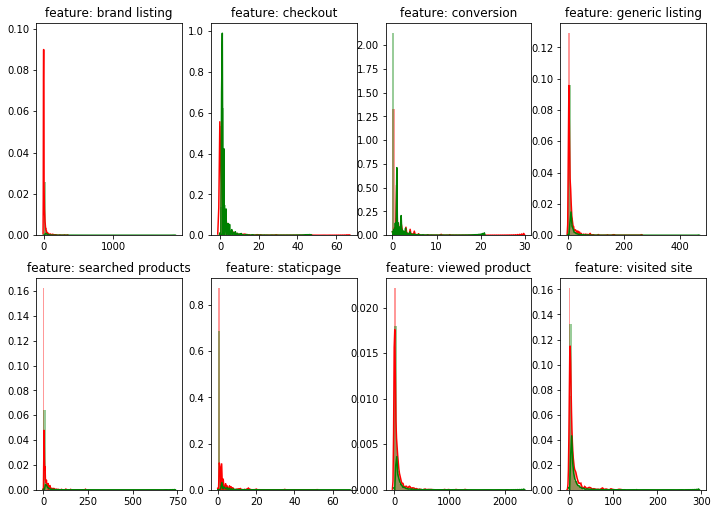

In [35]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(eventos_x_person[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(eventos_x_person[cn][eventos_x_person.label == 1], bins=50,kde=True,color='r')
    sns.distplot(eventos_x_person[cn][eventos_x_person.label == 0], bins=50,kde=True,color='g')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [36]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)

In [37]:
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(eventos_x_person.iloc[:,1:9],eventos_x_person['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [38]:
for name, importance in zip(features, rnd_clf.feature_importances_):
    print('"' + name + '"'+" : ",importance,',')

"brand listing" :  0.1365537282474799 ,
"checkout" :  0.19325940588846158 ,
"conversion" :  0.03565484901675248 ,
"generic listing" :  0.13200385347192656 ,
"searched products" :  0.10388807028079394 ,
"staticpage" :  0.029957054770104716 ,
"viewed product" :  0.24073981989186755 ,
"visited site" :  0.127943218432613 ,


In [33]:
# Features
f1 = 'ad campaign hit'
f2 = 'brand listing'
f3 = 'checkout'
f4 = 'conversion'
f5 = 'generic listing'
f6 = 'search engine hit'
f7 = 'viewed product'
f8 = 'visited site'
f9 = 'searched products'

features = [f3,f4,f5,f8]

In [34]:
train.iloc[:,1:9]/= 10

In [55]:
train = eventos_x_person

In [56]:
eventos_x_person.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19414 entries, 0 to 38827
Data columns (total 10 columns):
person               19414 non-null object
brand listing        19414 non-null float64
checkout             19414 non-null float64
conversion           19414 non-null float64
generic listing      19414 non-null float64
searched products    19414 non-null float64
staticpage           19414 non-null float64
viewed product       19414 non-null float64
visited site         19414 non-null float64
label                19414 non-null float64
dtypes: float64(9), object(1)
memory usage: 2.3+ MB


In [57]:
n_samples = 1000

modelo_no = train.loc[train['label'] == 1.0]
modelo_si = train.loc[train['label'] == 0.0].sample(n_samples)

modelo_final = pd.concat([modelo_no, modelo_si])

modelo_final.sample(5)

,person,brand listing,checkout,conversion,generic listing,searched products,staticpage,viewed product,visited site,label
24137,9fbc9d91,7.0,0.0,0.0,2.0,1.0,0.0,14.0,7.0,1.0
21113,8c27c9a2,1.0,1.0,0.0,2.0,0.0,0.0,48.0,2.0,1.0
8408,37e98fe5,16.0,0.0,0.0,4.0,0.0,0.0,54.0,2.0,1.0
25593,a9427fc9,0.0,2.0,0.0,1.0,0.0,0.0,16.0,1.0,0.0
32167,d44923a0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0


In [52]:
modelo_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 22520 to 19581
Data columns (total 10 columns):
person               1200 non-null object
brand listing        1200 non-null float64
checkout             1200 non-null float64
conversion           1200 non-null float64
generic listing      1200 non-null float64
searched products    1200 non-null float64
staticpage           1200 non-null float64
viewed product       1200 non-null float64
visited site         1200 non-null float64
label                1200 non-null float64
dtypes: float64(9), object(1)
memory usage: 103.1+ KB


In [58]:
modelo_final.to_csv('train_final.csv', encoding='utf-8', index=False)
